In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from PIL import Image
from  IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()

Using device: cuda


## Self-Supservised Learning

In [3]:
class ContrastiveDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = self.get_file_list()

    def get_file_list(self):
        file_list = []
        anchor_dir = os.path.join(self.root_dir, 'Anchor')
        for file in os.listdir(anchor_dir):
            if file.endswith('.jpg'):
                file_path = os.path.join(anchor_dir, file)
                file_list.append(file_path)
        return file_list

    def __len__(self):
        return len(self.file_list)
    
    def visualize(self, **images): 
        n = len(images)
        plt.figure(figsize=(16, 5))
        for i, (name, image) in enumerate(images.items()):
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(' '.join(name.split('_')).title())
            plt.imshow(image)
        plt.show()

    def __getimages__(self, idx):
        splits_pathA = os.path.dirname(self.file_list[idx])
        anc_filename = os.path.basename(self.file_list[idx])
        pos_filename = anc_filename.replace("Anchor", "Positive")
        splits_pathP = splits_pathA.replace("Anchor", "Positive")
        neg_filename = anc_filename.replace("Anchor", "Negative")
        splits_pathN = splits_pathA.replace("Anchor", "Negative")
        anchor_img = Image.open(os.path.join(splits_pathA, anc_filename)).convert('RGB')
        pos_img = Image.open(os.path.join(splits_pathP, pos_filename)).convert('RGB')
        neg_img = Image.open(os.path.join(splits_pathN, neg_filename)).convert('RGB')
        return anchor_img, pos_img, neg_img

    def __plot__triplet__(self, idx):
        anchor_img, pos_img, neg_img = self.__getimages__(idx)
        images = {'Anchor':anchor_img,'Positive':pos_img,'Negative':neg_img}    
        self.visualize(**images)

    def __getitem__(self, idx):
        anchor_img, pos_img, neg_img = self.__getimages__(idx)
        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anchor_img, pos_img, neg_img

In [4]:
root_dir = "./ssl_triplets_dataset_ohp/"
transform = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = ContrastiveDataset(root_dir, transform=transform)
total_samples = len(dataset)
train_size = int(0.7 * total_samples)
test_size = int(0.15 * total_samples)
valid_size = total_samples - train_size - test_size

In [5]:
batch_size = 32
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [6]:
dataset.__len__()

107820

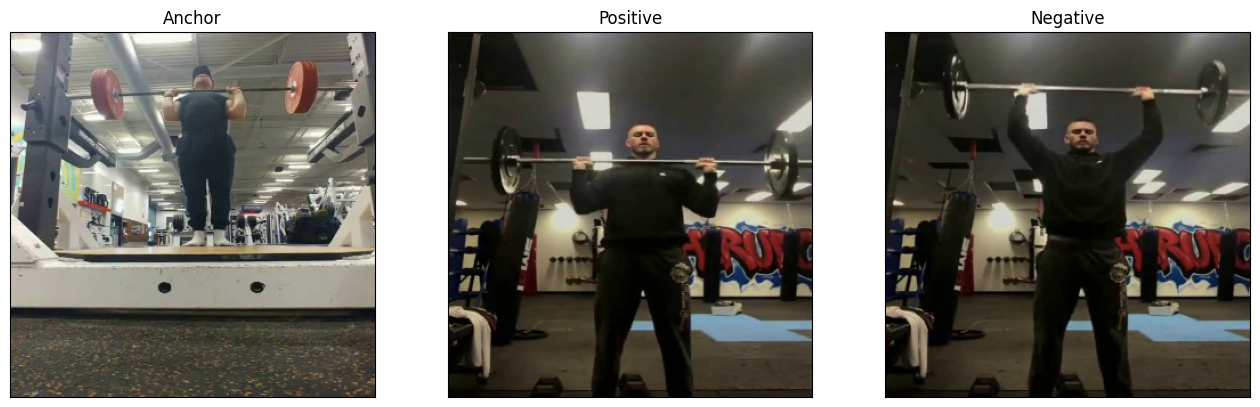

In [7]:
dataset.__plot__triplet__(0)

In [8]:
class ContrastiveModel(nn.Module):
    def __init__(self):
        super(ContrastiveModel, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.encoder.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.encoder.fc = torch.nn.Identity()

    def forward(self, x):
        return self.encoder(x)

In [9]:
class DistanceRatioLoss(nn.Module):
    def __init__(self):
        super(DistanceRatioLoss, self).__init__()
    
    def forward(self, anchor, positive, negative):
        epsilon = 1e-8
        dist_pos = torch.sqrt(torch.sum(torch.pow(anchor - positive, 2), dim=1))
        dist_neg = torch.sqrt(torch.sum(torch.pow(anchor - negative, 2), dim=1))
        dist_pos = torch.exp(-dist_pos)
        dist_neg = torch.exp(-dist_neg)
        loss = torch.mean(torch.clamp(-torch.log((dist_pos+epsilon)/(dist_pos+dist_neg+epsilon)), min=0))
        return loss

In [10]:
learning_rate = 0.0001
model = ContrastiveModel()
model.to(device)
criterion = DistanceRatioLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [11]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (anchor, positive, negative) in enumerate(train_dataloader):
        optimizer.zero_grad()
        anchor_emb = model(anchor.to(device))
        positive_emb = model(positive.to(device))
        negative_emb = model(negative.to(device))
        loss = criterion(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{} ({:.2f}%)], Train Loss: {:.4f}'
                  .format(epoch+1, num_epochs, batch_idx+1, len(train_dataloader), (100*batch_idx+1)/len(train_dataloader), loss.item()))
    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in enumerate(valid_dataloader):
            anchor_emb = model(anchor.to(device))
            positive_emb = model(positive.to(device))
            negative_emb = model(negative.to(device))
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            val_loss += loss.item()
        val_loss /= len(valid_dataloader)

    # Imprimir la pérdida de entrenamiento y validación
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    
    torch.save(checkpoint, 'checkpoint_ssl_18.pt')

Epoch [1/100], Step [1/2359 (0.00%)], Train Loss: 0.2712
Epoch [1/100], Step [101/2359 (4.24%)], Train Loss: 0.0252
Epoch [1/100], Step [201/2359 (8.48%)], Train Loss: 0.0229
Epoch [1/100], Step [301/2359 (12.72%)], Train Loss: 0.0043
Epoch [1/100], Step [401/2359 (16.96%)], Train Loss: 0.0228
Epoch [1/100], Step [501/2359 (21.20%)], Train Loss: 0.0040
Epoch [1/100], Step [601/2359 (25.43%)], Train Loss: 0.0055
Epoch [1/100], Step [701/2359 (29.67%)], Train Loss: 0.0041
Epoch [1/100], Step [801/2359 (33.91%)], Train Loss: 0.0022
Epoch [1/100], Step [901/2359 (38.15%)], Train Loss: 0.0082
Epoch [1/100], Step [1001/2359 (42.39%)], Train Loss: 0.0006
Epoch [1/100], Step [1101/2359 (46.63%)], Train Loss: 0.0024
Epoch [1/100], Step [1201/2359 (50.87%)], Train Loss: 0.0018
Epoch [1/100], Step [1301/2359 (55.11%)], Train Loss: 0.0008
Epoch [1/100], Step [1401/2359 (59.35%)], Train Loss: 0.0006
Epoch [1/100], Step [1501/2359 (63.59%)], Train Loss: 0.0278
Epoch [1/100], Step [1601/2359 (67.83%)

KeyboardInterrupt: 

In [12]:
checkpoint = torch.load("./checkpoint_ssl_18.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 

In [13]:
def test():
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchor, positive, negative) in enumerate(test_dataloader):
            anchor_emb = model(anchor.to(device))
            positive_emb = model(positive.to(device))
            negative_emb = model(negative.to(device))
            loss = criterion(anchor_emb, positive_emb, negative_emb)
            test_loss += loss.item()
        test_loss /= len(test_dataloader)

    print('Test Loss: {:.4f}'.format(test_loss))

In [14]:
test()

Test Loss: 0.0016
